<h3>Data Munging</h3>
Preparing the data for analysis...

In [2]:
fpath = '/Users/paulp/Downloads/'
file = 'BGI_WGM2012_EXTRACT_Bouguer.txt'

df = pd.read_table(fpath+file, delim_whitespace=True, names=['Longitude','Latitude','Gravity'], skiprows=5)


In [5]:
df.to_csv(fpath+'WGM2012.csv', names=['id','Longitude','Latitude','Gravity'])

In [ ]:
# import WGM2012.csv into GRASS and interpolate to 30sec gravity DSM

v.in.ascii input=/Users/paulp/Downloads/WGM2012.csv output=WGM2012xyz separator=comma skip=1 x=2 y=3 z=4 cat=1

r.mask vector=margins_sampling_windows@user

v.surf.rst input=WGM2012xyz@user elevation=WGM2012_BGravAnomaly_Global_30sec npmin=120

In [ ]:
# Generate a 20k point random sampling of points across the 9 sampling areas, then conflate the topobathy (z), crustal
# thickness (to the Moho), magnetic and gravity anomalies to PAT...

r.random input=GEMMA_CrustThkness_Global_30sec@user npoints=20000 vector=CMM_20krandompnts

# added fields: CrustThk, Elevation, Magnetic,Gravity, and gForms to the CMM_20krandompnts PAT...
    
v.what.rast map=CMM_20krandompnts@user raster=EMAG2_V3_SeaLevel_DataTiff@user column=Magnetic
v.what.rast map=CMM_20krandompnts@user raster=WGM2012_BGravAnomaly_Global_30sec@user column=Gravity
v.what.rast map=CMM_20krandompnts@user raster=GEBCO_2014_2D@user column=Elevation

In [ ]:
# generate geomorphon forms and ternary patterns for the GEBCO topobathy in the sample areas, then populate gForms field in
# CMM_20krandompnts' PAT with the forms values:

r.geomorphon elevation=GEBCO_2014_2D@user forms=GEBCO_gForms_SampleAreas_30sec ternary=GEBCO_gTernary_SampleAreas_30sec search=3 skip=0 flat=0.69 dist=0
v.what.rast map=CMM_20krandompnts@user raster=GEBCO_gForms_SampleAreas_30sec@user column=gForms

In [ ]:
# Export the resulting sample points PAT out into the 'wild' as a comma-separated values file:
v.out.ogr input=CMM_20krandompnts@user output=/Users/paulp/randompnts format=CSV

<h3>Data load</h3> 
Loading data into Pandas in prep for EDA...

NOTE: for the geomorphon forms:
- flat = 0
- slope = 6
- footslope = 8

In [1]:
fpath='/Users/paulp/GoogleDrive/projects/ContinentalMarginMapping/data/GCS_EDA_sampling/'
file='CMM_20krandompnts.csv'

df = pd.read_csv(fpath+file, names=['ID','CrustThk','Elevation','Magnetic','Gravity','gForms'], skiprows=1).dropna()

<h3>EDA</h3>

In [2]:
df.describe()


pd.crosstab(df.Magnetic > df['Magnetic'].mean(), df.CrustThk > df.CrustThk.mean())

CrustThk,False,True
Magnetic,,
False,4282,5984
True,3561,5498


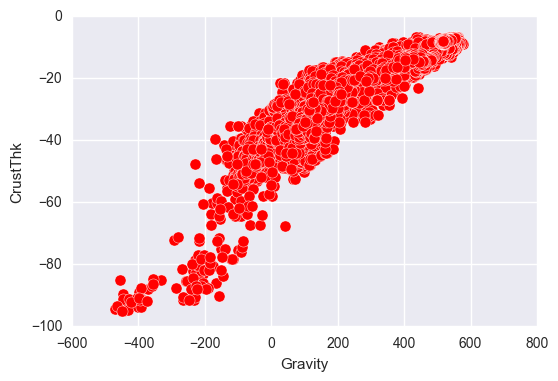

In [7]:
%matplotlib inline

#df.boxplot(return_type='axes')

sp = df.plot(kind='scatter', x='Gravity', y='CrustThk', s=64, c='red', edgecolors='white')      # pos corr
#sp = df.plot(kind='scatter', x='Gravity', y='Elevation', s=64, c='red', edgecolors='white')    # neg corr
#sp = df.plot(kind='scatter', x='Magnetic', y='Elevation', s=7, c='red', edgecolors='white')   # lo corr
#sp = df.plot(kind='scatter', x='Magnetic', y='CrustThk', s=7, c='red', edgecolors='white')     # interesting symmetry
#sp = df.plot(kind='scatter', x='Magnetic', y='Gravity', s=7, c='red', edgecolors='white')